## Import libraries and mount the drive

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

2.1.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('./drive/My Drive/Master_thesis/generation')
from dataset_helpers import load_dataset

## Loading the validation and test sets

In [0]:
def load_datasets():
    validation = load_dataset(prefix_path + 'brats2015_validation_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=False)
    training = load_dataset(prefix_path + 'brats2015_training_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=True)
    testing = load_dataset(prefix_path + 'brats2015_testing_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=True)
    return training, validation , testing

In [0]:
prefix_path = './drive/My Drive/Master_thesis/datasets/'
BATCH_SIZE = 32

training, validation, testing = load_datasets()

## Load some useful functions




In [0]:
def resize_with_crop(*args): # possibile arguments: input, gt, prediction and maybe the segmentation

    image0 = tf.image.resize_with_crop_or_pad(args[0], 155, 194)
    image1 = tf.image.resize_with_crop_or_pad(args[1], 155, 194)
    image2 = tf.image.resize_with_crop_or_pad(args[2], 155, 194)
    image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
    if len(args) == 5:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        return image0, image1, image2, image3, image4
    if len(args) == 7:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        image6 = tf.image.resize_with_crop_or_pad(args[6], 155, 194)
        return image0, image1, image2, image3, image4, image5, image6
    if len(args) == 8:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        image6 = tf.image.resize_with_crop_or_pad(args[6], 155, 194)
        image7 = tf.image.resize_with_crop_or_pad(args[7], 155, 194)
        return image0, image1, image2, image3, image4, image5, image6, image7
    return image0, image1, image2, image3

In [0]:
# MASK THE SEGMENTATION with the prediciton and the ground_truth and then compute the metrics (even if there is the black pixels
# it should give me an idea about how much is going the generation of the tumor during the generation. of course the score
# will be influeced (biased) by all the black pixels.)

def retrieve_tumor_area(*args):  # ground_truth, prediction1, prediction2, segmentation, prediction3*
    ground_truth_np = args[0].numpy()
    prediction1_np = args[1].numpy()
    prediction2_np = args[2].numpy()
    segmentation_np = args[3].numpy()
    if len(args) == 5:
        prediction3_np = args[4].numpy()
    
    # I want to remove all the pixels not relevant wrt the tumor area. 
    idx = (segmentation_np==0)      
    ground_truth_np[idx] = segmentation_np[idx]
    prediction1_np[idx] = segmentation_np[idx]
    prediction2_np[idx] = segmentation_np[idx]
    if len(args) == 5:
        prediction3_np[idx] = segmentation_np[idx]
        return ground_truth_np, prediction1_np, prediction2_np, prediction3_np

    return ground_truth_np, prediction1_np, prediction2_np      # Now the images are ready to be evaluated

In [0]:
def plot_images(*args): 
    if len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]]   # input, gt, prediction, gt masked, pred masked
        title = ['T1', 'T2', 'Tflair', 'T1c - ground Truth', 'T1c - Predicted Image']
        figsize = (14, 7)
    elif len(args) == 3:
        display_list = [args[0], args[1], args[2]]   # input, gt and prediction
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        figsize = (8, 4)

    elif len(args) == 6:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5]]
        title = ['T1', 'T2', 'Tflair', 'T1c - ground Truth', 'T1c pix2pix prediction', 'T1c MI-GAN prediction']
        figsize = (20, 6)

    elif len(args) == 7:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6]]
        title = ['T1', 'T2', 'Tflair', 'T1c - ground Truth', 'T1c pix2pix prediction', 'T1c MI-GAN prediction', 'T1c MI-pix2pix prediction']
        figsize = (21, 8)

    elif len(args) == 9:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8]]
        title = ['T1', 'T2', 'Tflair', 'T1c - ground Truth', 'T1c pix2pix prediction', 'T1c MI-GAN prediction', 'GT Tumor', 'pix2pix pred tumor', 'MI-GAN pred tumor']

        figsize = (23, 12)

    elif len(args) == 11:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9], args[10]]
        title = ['T1', 'T2', 'Tflair', 'T1c - ground Truth', 'T1c pix2pix prediction', 'T1c MI-GAN prediction', 'T1c MI-pix2pix prediction','GT Tumor', 'pix2pix pred tumor', 'MI-GAN pred tumor', 'MI-pix2pix pred tumor']

        figsize = (30, 15)
    
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):    # batch size is different from 10, but let's show just 10 images.
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone')
        plt.axis('off')
    plt.show()

## Evaluate GAN

In [0]:
def evaluate_GAN(*args, dataset, set_type, evaluate_tumor_area=False):
    num_batches = 0                 # CAREFUL when batch_size is modified!!!
    if set_type == 'test':
        num_batches = 112           # in the test set, with batch 32, there are 112 elements.
    elif set_type == 'validation':
        num_batches = 108
    elif set_type == 'train':
        num_batches = 876
    
    container_psnr1 = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse1 = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim1 = tf.TensorArray(tf.float32, size=num_batches)
    container_psnr2 = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse2 = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim2 = tf.TensorArray(tf.float32, size=num_batches)
    if len(args) == 3:      # if a third model to be evaluated is given in input
        container_psnr3 = tf.TensorArray(tf.float32, size=num_batches)     
        container_mse3 = tf.TensorArray(tf.float32, size=num_batches)
        container_ssim3 = tf.TensorArray(tf.float32, size=num_batches)
    
    if evaluate_tumor_area:
        container_psnr_tumor1 = tf.TensorArray(tf.float32, size=num_batches)     
        container_mse_tumor1 = tf.TensorArray(tf.float32, size=num_batches)
        container_ssim_tumor1 = tf.TensorArray(tf.float32, size=num_batches)
        container_psnr_tumor2 = tf.TensorArray(tf.float32, size=num_batches)     
        container_mse_tumor2 = tf.TensorArray(tf.float32, size=num_batches)
        container_ssim_tumor2 = tf.TensorArray(tf.float32, size=num_batches)
        if len(args) == 3:
            container_psnr_tumor3 = tf.TensorArray(tf.float32, size=num_batches)     
            container_mse_tumor3 = tf.TensorArray(tf.float32, size=num_batches)
            container_ssim_tumor3 = tf.TensorArray(tf.float32, size=num_batches)

    for idx, (t1, t2, t1c, tflair, segmentation, patient) in dataset.enumerate():
        # preparing the input to the generator
    
        inp = t1
        input_tensor = tf.concat([t1, t2, tflair], 3)  # input MI-GAN
        ground_truth = t1c
            
        # generate the prediction  
        prediction1 = args[0](inp, training=False)              # pix2pix
        prediction2 = args[1](input_tensor, training=False)     # MI-GAN
        if len(args) == 3:
            prediction3 = args[2](input_tensor, training=False) # MI-pix2pix (only if is given in input)

        # crop the images
        if len(args) == 3:
            inp_cr, t2_cr, tflair_cr, ground_truth_cr, prediction1_cr, prediction2_cr, prediction3_cr, segmentation_cr = resize_with_crop(inp, t2, tflair, ground_truth, prediction1, prediction2, prediction3, segmentation)
            if evaluate_tumor_area:
                prediction1_norm = mean_normalize(prediction1_cr)
                prediction2_norm = mean_normalize(prediction2_cr)
                ground_truth_norm = mean_normalize(ground_truth_cr) 
                prediction3_norm = mean_normalize(prediction3_cr)
                
                ground_truth_masked_normalized, prediction1_masked_normalized, prediction2_masked_normalized, prediction3_masked_normalized = retrieve_tumor_area(ground_truth_norm, prediction1_norm, prediction2_norm, segmentation_cr, prediction3_norm)
        else:
            inp_cr, t2_cr, tflair_cr, ground_truth_cr, prediction1_cr, prediction2_cr, segmentation_cr = resize_with_crop(inp, t2, tflair, ground_truth, prediction1, prediction2, segmentation)
            if evaluate_tumor_area:
                prediction1_norm = mean_normalize(prediction1_cr)
                prediction2_norm = mean_normalize(prediction2_cr)
                ground_truth_norm = mean_normalize(ground_truth_cr) 
                
                ground_truth_masked_normalized, prediction1_masked_normalized, prediction2_masked_normalized = retrieve_tumor_area(ground_truth_norm, prediction1_norm, prediction2_norm, segmentation_cr)


        # let's print only 5 images per time. 
        
        if (idx == 2 or idx == 26 or idx == 29 or idx == 6 or idx == 72 or idx == 59 or idx == 34 or idx == 11 or idx == 75 or idx == 109 or idx == 95):
            if len(args) == 2:
                if evaluate_tumor_area: #9
                    plot_images(inp_cr, t2_cr, tflair_cr, ground_truth_cr, prediction1_cr, prediction2_cr, ground_truth_masked_normalized, 
                                    prediction1_masked_normalized, prediction2_masked_normalized)
                else: #6
                    plot_images(inp_cr, t2_cr, tflair_cr, ground_truth_cr, prediction1_cr, prediction2_cr)
            else:
                if evaluate_tumor_area: #11
                    plot_images(inp_cr, t2_cr, tflair_cr, ground_truth_cr, prediction1_cr, prediction2_cr, prediction3_cr, 
                                    ground_truth_masked_normalized, prediction1_masked_normalized, prediction2_masked_normalized, prediction3_masked_normalized)
                else:#7
                    plot_images(inp_cr, t2_cr, tflair_cr, ground_truth_cr, prediction1_cr, prediction2_cr, prediction3_cr)

        
        # normalize the predictions and the ground_truth
        prediction1_normalized_cr = mean_normalize(prediction1_cr)
        prediction2_normalized_cr = mean_normalize(prediction2_cr)
        ground_truth_normalized_cr = mean_normalize(ground_truth_cr)
        if len(args) == 3:
            prediction3_normalized_cr = mean_normalize(prediction3_cr)
            mean, std, psnr = compute_psnr(ground_truth_normalized_cr, prediction3_normalized_cr)
            container_psnr3 = container_psnr3.write(idx, psnr)
            mean, std, mse = compute_mse(ground_truth_normalized_cr, prediction3_normalized_cr)
            container_mse3 = container_mse3.write(idx, mse)
            mean, std, ssim = compute_ssim(ground_truth_normalized_cr, prediction3_normalized_cr)
            container_ssim3 = container_ssim3.write(idx, ssim)

        # compute the metrics of similarity
        mean, std, psnr = compute_psnr(ground_truth_normalized_cr, prediction1_normalized_cr)
        container_psnr1 = container_psnr1.write(idx, psnr)
        mean, std, mse = compute_mse(ground_truth_normalized_cr, prediction1_normalized_cr)
        container_mse1 = container_mse1.write(idx, mse)
        mean, std, ssim = compute_ssim(ground_truth_normalized_cr, prediction1_normalized_cr)
        container_ssim1 = container_ssim1.write(idx, ssim)

        mean, std, psnr = compute_psnr(ground_truth_normalized_cr, prediction2_normalized_cr)
        container_psnr2 = container_psnr2.write(idx, psnr)
        mean, std, mse = compute_mse(ground_truth_normalized_cr, prediction2_normalized_cr)
        container_mse2 = container_mse2.write(idx, mse)
        mean, std, ssim = compute_ssim(ground_truth_normalized_cr, prediction2_normalized_cr)
        container_ssim2 = container_ssim2.write(idx, ssim)

        if evaluate_tumor_area:
            mean, std, psnr = compute_psnr_tumor(ground_truth_masked_normalized, prediction1_masked_normalized)
            container_psnr_tumor1 = container_psnr_tumor1.write(idx, psnr)
            mean, std, mse = compute_mse_tumor(ground_truth_masked_normalized, prediction1_masked_normalized)
            container_mse_tumor1 = container_mse_tumor1.write(idx, mse)
            mean, std, ssim = compute_ssim(ground_truth_masked_normalized, prediction1_masked_normalized)
            container_ssim_tumor1 = container_ssim_tumor1.write(idx, ssim)

            mean, std, psnr = compute_psnr_tumor(ground_truth_masked_normalized, prediction2_masked_normalized)
            container_psnr_tumor2 = container_psnr_tumor2.write(idx, psnr)
            mean, std, mse = compute_mse_tumor(ground_truth_masked_normalized, prediction2_masked_normalized)
            container_mse_tumor2 = container_mse_tumor2.write(idx, mse)
            mean, std, ssim = compute_ssim(ground_truth_masked_normalized, prediction2_masked_normalized)
            container_ssim_tumor2 = container_ssim_tumor2.write(idx, ssim)

            if len(args) == 3:
                mean, std, psnr = compute_psnr_tumor(ground_truth_masked_normalized, prediction3_masked_normalized)
                container_psnr_tumor3 = container_psnr_tumor3.write(idx, psnr)
                mean, std, mse = compute_mse_tumor(ground_truth_masked_normalized, prediction3_masked_normalized)
                container_mse_tumor3 = container_mse_tumor3.write(idx, mse)
                mean, std, ssim = compute_ssim(ground_truth_masked_normalized, prediction3_masked_normalized)
                container_ssim_tumor3 = container_ssim_tumor3.write(idx, ssim)
    
    container_psnr1 = container_psnr1.stack()
    container_mse1 = container_mse1.stack()
    container_ssim1 = container_ssim1.stack()

    container_psnr2 = container_psnr2.stack()
    container_mse2 = container_mse2.stack()
    container_ssim2 = container_ssim2.stack()

    mean_psnr1 = tf.reduce_mean(tf.boolean_mask((container_psnr1), tf.math.is_finite(container_psnr1)))
    std_psnr1 = tf.math.reduce_std(tf.boolean_mask((container_psnr1), tf.math.is_finite(container_psnr1)))
    mean_mse1 = tf.reduce_mean(tf.boolean_mask((container_mse1), tf.math.is_finite(container_mse1)))
    std_mse1 = tf.math.reduce_std(tf.boolean_mask((container_mse1), tf.math.is_finite(container_mse1)))
    mean_ssim1 = tf.reduce_mean(tf.boolean_mask((container_ssim1), tf.math.is_finite(container_ssim1)))
    std_ssim1 = tf.math.reduce_std(tf.boolean_mask((container_ssim1), tf.math.is_finite(container_ssim1)))
    
    print("PSNR pix2pix on {} set: {} ± {}".format(set_type, (f'{mean_psnr1:.4f}'), (f'{std_psnr1:.4f}')))
    print("MSE pix2pix on {} set: {} ± {}".format(set_type, (f'{mean_mse1:.4f}'), (f'{std_mse1:.4f}')))
    print("SSIM pix2pix on {} set: {} ± {}".format(set_type, (f'{mean_ssim1:.4f}'), (f'{std_ssim1:.4f}')))

    mean_psnr2 = tf.reduce_mean(tf.boolean_mask((container_psnr2), tf.math.is_finite(container_psnr2)))
    std_psnr2 = tf.math.reduce_std(tf.boolean_mask((container_psnr2), tf.math.is_finite(container_psnr2)))
    mean_mse2 = tf.reduce_mean(tf.boolean_mask((container_mse2), tf.math.is_finite(container_mse2)))
    std_mse2 = tf.math.reduce_std(tf.boolean_mask((container_mse2), tf.math.is_finite(container_mse2)))
    mean_ssim2 = tf.reduce_mean(tf.boolean_mask((container_ssim2), tf.math.is_finite(container_ssim2)))
    std_ssim2 = tf.math.reduce_std(tf.boolean_mask((container_ssim2), tf.math.is_finite(container_ssim2)))
    print()
    print("PSNR MI-GAN on {} set: {} ± {}".format(set_type, (f'{mean_psnr2:.4f}'), (f'{std_psnr2:.4f}')))
    print("MSE MI-GAN on {} set: {} ± {}".format(set_type, (f'{mean_mse2:.4f}'), (f'{std_mse2:.4f}')))
    print("SSIM MI-GAN on {} set: {} ± {}".format(set_type, (f'{mean_ssim2:.4f}'), (f'{std_ssim2:.4f}')))
    print()
    if len(args) == 3:
        container_psnr3 = container_psnr3.stack()
        container_mse3 = container_mse3.stack()
        container_ssim3 = container_ssim3.stack()

        mean_psnr3 = tf.reduce_mean(tf.boolean_mask((container_psnr3), tf.math.is_finite(container_psnr3)))
        std_psnr3 = tf.math.reduce_std(tf.boolean_mask((container_psnr3), tf.math.is_finite(container_psnr3)))
        mean_mse3 = tf.reduce_mean(tf.boolean_mask((container_mse3), tf.math.is_finite(container_mse3)))
        std_mse3 = tf.math.reduce_std(tf.boolean_mask((container_mse3), tf.math.is_finite(container_mse3)))
        mean_ssim3 = tf.reduce_mean(tf.boolean_mask((container_ssim3), tf.math.is_finite(container_ssim3)))
        std_ssim3 = tf.math.reduce_std(tf.boolean_mask((container_ssim3), tf.math.is_finite(container_ssim3)))
        
        print("PSNR MI-pix2pix on {} set: {} ± {}".format(set_type, (f'{mean_psnr3:.4f}'), (f'{std_psnr3:.4f}')))
        print("MSE MI-pix2pix on {} set: {} ± {}".format(set_type, (f'{mean_mse3:.4f}'), (f'{std_mse3:.4f}')))
        print("SSIM MI-pix2pix on {} set: {} ± {}".format(set_type, (f'{mean_ssim3:.4f}'), (f'{std_ssim3:.4f}')))

    if evaluate_tumor_area:

        threshold = 228
        container_psnr_tumor1 = container_psnr_tumor1.stack()
        container_mse_tumor1 = container_mse_tumor1.stack()
        container_ssim_tumor1 = container_ssim_tumor1.stack()

        container_psnr_tumor2 = container_psnr_tumor2.stack()
        container_mse_tumor2 = container_mse_tumor2.stack()
        container_ssim_tumor2 = container_ssim_tumor2.stack()

        container_psnr_tumor1 = tf.boolean_mask((container_psnr_tumor1), tf.math.is_finite(container_psnr_tumor1))
        container_psnr_tumor1 = container_psnr_tumor1[container_psnr_tumor1 < threshold]
        container_psnr_tumor2 = tf.boolean_mask((container_psnr_tumor2), tf.math.is_finite(container_psnr_tumor2))
        container_psnr_tumor2 = container_psnr_tumor2[container_psnr_tumor2 < threshold]

        mean_psnr_tumor1 = tf.reduce_mean(container_psnr_tumor1)
        std_psnr_tumor1 = tf.math.reduce_std(container_psnr_tumor1)
        mean_mse_tumor1 = tf.reduce_mean(tf.boolean_mask((container_mse_tumor1), tf.math.is_finite(container_mse_tumor1)))
        std_mse_tumor1 = tf.math.reduce_std(tf.boolean_mask((container_mse_tumor1), tf.math.is_finite(container_mse_tumor1)))
        mean_ssim_tumor1 = tf.reduce_mean(tf.boolean_mask((container_ssim_tumor1), tf.math.is_finite(container_ssim_tumor1)))
        std_ssim_tumor1 = tf.math.reduce_std(tf.boolean_mask((container_ssim_tumor1), tf.math.is_finite(container_ssim_tumor1)))
        print()
        print("PSNR pix2pix wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_psnr_tumor1:.4f}'), (f'{std_psnr_tumor1:.4f}')))
        print("MSE pix2pix wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_mse_tumor1:.4f}'), (f'{std_mse_tumor1:.4f}')))
        print("SSIM pix2pix wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_ssim_tumor1:.4f}'), (f'{std_ssim_tumor1:.4f}')))

        mean_psnr_tumor2 = tf.reduce_mean(container_psnr_tumor2)
        std_psnr_tumor2 = tf.math.reduce_std(container_psnr_tumor2)
        mean_mse_tumor2 = tf.reduce_mean(tf.boolean_mask((container_mse_tumor2), tf.math.is_finite(container_mse_tumor2)))
        std_mse_tumor2 = tf.math.reduce_std(tf.boolean_mask((container_mse_tumor2), tf.math.is_finite(container_mse_tumor2)))
        mean_ssim_tumor2 = tf.reduce_mean(tf.boolean_mask((container_ssim_tumor2), tf.math.is_finite(container_ssim_tumor2)))
        std_ssim_tumor2 = tf.math.reduce_std(tf.boolean_mask((container_ssim_tumor2), tf.math.is_finite(container_ssim_tumor2)))
        print()
        print("PSNR MI-GAN wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_psnr_tumor2:.4f}'), (f'{std_psnr_tumor2:.4f}')))
        print("MSE MI-GAN wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_mse_tumor2:.4f}'), (f'{std_mse_tumor2:.4f}')))
        print("SSIM MI-GAN wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_ssim_tumor2:.4f}'), (f'{std_ssim_tumor2:.4f}')))

        if len(args) == 3:
            container_psnr_tumor3 = container_psnr_tumor3.stack()
            container_mse_tumor3 = container_mse_tumor3.stack()
            container_ssim_tumor3 = container_ssim_tumor3.stack()

            container_psnr_tumor3 = tf.boolean_mask((container_psnr_tumor3), tf.math.is_finite(container_psnr_tumor3))
            container_psnr_tumor3 = container_psnr_tumor3[container_psnr_tumor3 < threshold]

            mean_psnr_tumor3 = tf.reduce_mean(container_psnr_tumor3)
            std_psnr_tumor3 = tf.math.reduce_std(container_psnr_tumor3)
            mean_mse_tumor3 = tf.reduce_mean(tf.boolean_mask((container_mse_tumor3), tf.math.is_finite(container_mse_tumor3)))
            std_mse_tumor3 = tf.math.reduce_std(tf.boolean_mask((container_mse_tumor3), tf.math.is_finite(container_mse_tumor3)))
            mean_ssim_tumor3 = tf.reduce_mean(tf.boolean_mask((container_ssim_tumor3), tf.math.is_finite(container_ssim_tumor3)))
            std_ssim_tumor3 = tf.math.reduce_std(tf.boolean_mask((container_ssim_tumor3), tf.math.is_finite(container_ssim_tumor3)))
            print()
            print("PSNR MI-pix2pix wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_psnr_tumor3:.4f}'), (f'{std_psnr_tumor3:.4f}')))
            print("MSE MI-pix2pix wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_mse_tumor3:.4f}'), (f'{std_mse_tumor3:.4f}')))
            print("SSIM MI-pix2pix wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_ssim_tumor3:.4f}'), (f'{std_ssim_tumor3:.4f}')))



## Mean normalization

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5c591a0eeba163a12f69f937adbae5886d6273db)

In the paper they say: "Each patient scan is normalized by dividing each sequence by its mean intensity value. "
But the formula is taken from a lecture from Andrew Ng, where he defines the Mean normalization as in the formula above. (resource: https://www.youtube.com/watch?v=e1nTgoDI_m8)

See also: https://stats.stackexchange.com/questions/138046/normalizations-dividing-by-mean

In [0]:
def mean_rescale(x, xmin, xmax):
    mean = tf.reduce_mean(x)
    return ((x-mean)/(xmax-xmin)) 

In [0]:
@tf.function
def mean_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = mean_rescale(image[i], min_value, max_value)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

## Discard black images from batch (put values to 'nan')

This normalization is just to test the metrics and see if there is a big difference in normalizing the prediction and the gt.
This method is used to normalize (and so put to 'nan') only the black images, while the other images of the batch are kept with the original values. This allows me to discard the black images in the computation of the metrics.

In [0]:
# this normalization is just to test the metrics and see if there is a big difference in normalizing the prediction and the gt.
# this method is used to normalize (and so put to 'nan') only the black images, while the other images of the batch are kept 
# with the original values. This allows me to discard the black images in the computation of the metrics.

def black_images_to_nan(image): 
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])

        # if the max = min most likely it's a black image (or an image without any important information)
        if tf.math.equal(max_value, min_value):        
            print("I found a black image! at index {}".format(i))
            x = mean_normalize(image[i], min_value, max_value)
            image_normalized = image_normalized.write(i, x)
        else:
            image_normalized = image_normalized.write(i, image[i])
    image_normalized = image_normalized.stack()
    return image_normalized

##Defining all the quantitative metrics (PSNR, SSIM and MSE)

In [0]:
def compute_psnr(image1, image2):
    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    psnr = tf.image.psnr(im1, im2, max_val=1.0)
    mean = tf.reduce_mean(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    # In the computation of mean and std, I'm ignoring the 'nan' and 'inf' values
    # Why 'nan' values? 'nan' happens when there is an image with max_value and min_value = 0.0 so a black image
    # the PSNR would be inf (image is totally similar to the ground truth)
    # be rescaling the image, the max_value and min_value would become nan and so the PSNR

    # It ignores also the 'inf' values, in the case I don't want to normalize
    
    return mean, std, psnr

In [0]:
def compute_ssim(image1, image2):
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(im1, im2, max_val=1)
    mean = tf.reduce_mean(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    std = tf.math.reduce_std(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    return mean, std, ssim

In [0]:
# I want to compute, first thing, the MSE between ground truth and generated one. The tf.function gives me a Tensor 32x256x256:
# MSE is computed PIXEL per PIXEL, so per each of the 32 matrix 256x256, I average (1) the values of the 256x256 pixels obtaining
# an array of 32 elements, containing the MSEs of each image belonging to the batch. Then I can average (2) these 32 to have 
# I should not average the whole 32x256x256 in one step. The result would have same mean but slightly different std.
# I want first to obtain the MSE of each image... then I average across the batch only to have smth more accurate.

def compute_mse(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    mse = tf.metrics.mean_squared_error(im1,im2)
    # In this way is possible to do Variable item-assignment with tensors 
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        x = tf.reduce_mean(tf.boolean_mask((mse[i]), tf.math.is_finite(mse[i]))) 
        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std, mse_per_image

In [0]:
!pip install -q  --no-deps tensorflow-addons==0.6.0
import tensorflow_addons as tfa
print(tfa.__version__)

from tensorflow.python.ops import math_ops

def compute_mse_tumor(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    squared_difference = tf.math.squared_difference(im1,im2)
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        non_zero_elements = tf.math.count_nonzero(squared_difference[i], dtype=tf.dtypes.float32)
        sum_over_squared_difference = tf.math.reduce_sum(squared_difference[i])
        x = tf.math.divide(sum_over_squared_difference, non_zero_elements) 

        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std, mse_per_image


def compute_psnr_tumor(image1, image2):       # mean squared error
    max_val=1.0
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    squared_difference = tf.math.squared_difference(im1,im2)
    psnr_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        non_zero_elements = tf.math.count_nonzero(squared_difference[i], dtype=tf.dtypes.float32)
        sum_over_squared_difference = tf.math.reduce_sum(squared_difference[i])
        x = tf.math.divide(sum_over_squared_difference, non_zero_elements) 
        
        psnr_val = math_ops.subtract(20 * math_ops.log(max_val) / math_ops.log(10.0), np.float32(10 / np.log(10)) * math_ops.log(x), name='psnr')
        psnr_per_image = psnr_per_image.write(i, psnr_val)

    psnr_per_image = psnr_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((psnr_per_image), tf.math.is_finite(psnr_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr_per_image), tf.math.is_finite(psnr_per_image)))
    return mean, std, psnr_per_image

     |████████████████████████████████| 1.8MB 2.8MB/s 
0.6.0


## Load the model

I'll first load the model that in format 'h5'. Then test this model.

After this, I'll recover the generator, discriminator and optimizer states and test it. 
They should lead to the same results in the test set

In [0]:
# proposed model
MI_GAN_t1c = tf.keras.models.load_model('drive/My Drive/MRI-generation/MI-GAN/gen_t1c_40ep_v4.1.h5', compile=False)

#baseline
pix2pix_t1c = tf.keras.models.load_model('drive/My Drive/MRI-generation/pix2pix/gen_T1c_42ep.h5', compile=False)

In [0]:
MI_pix2pix_t1c = tf.keras.models.load_model('drive/My Drive/MRI-generation/MI-pix2pix/gen_t1c_50ep_v2.h5', compile=False)

## Evaluate performances of the model (using segmentation to evaluate the quality of the tumor generation) - TEST SET


I want to compute the metrics ONLY for the slices that present a segmentation, in order to understand how well that tumor was generated 

So I'll ignore the slices totally black. 

## Comparison between pix2pix, MI-GAN and MI-pix2pix where pix2pix generates T1c using T1

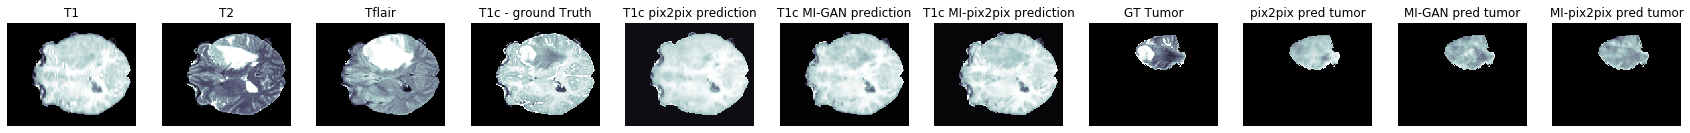

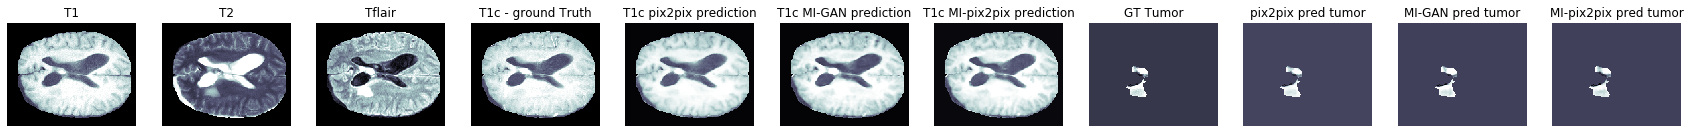

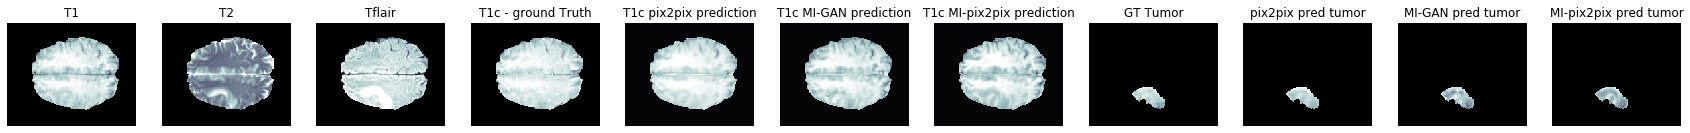

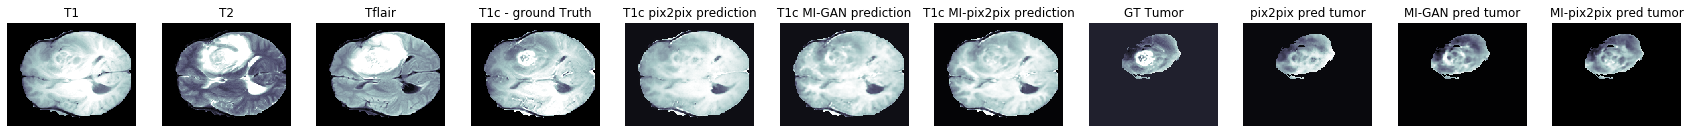

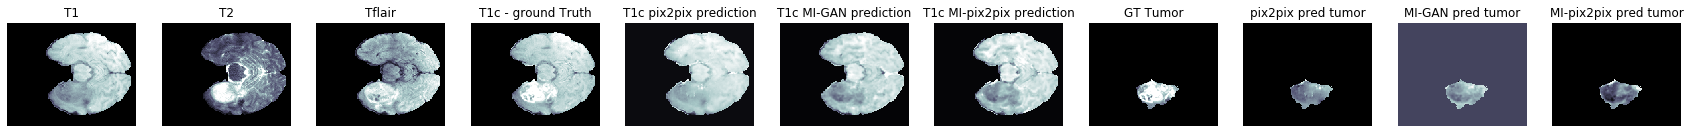

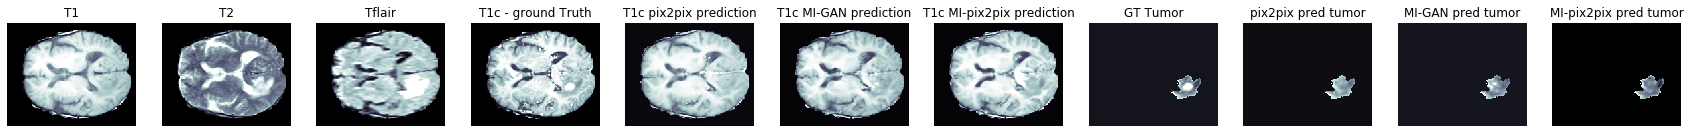

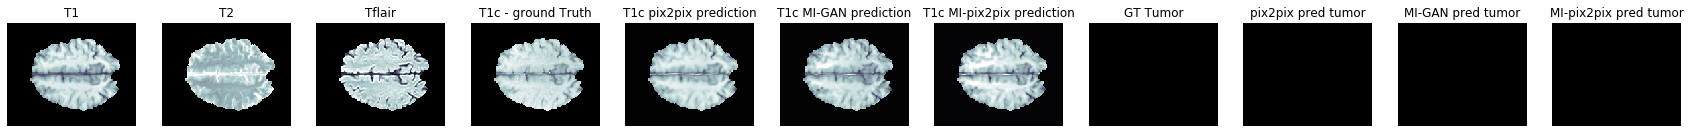

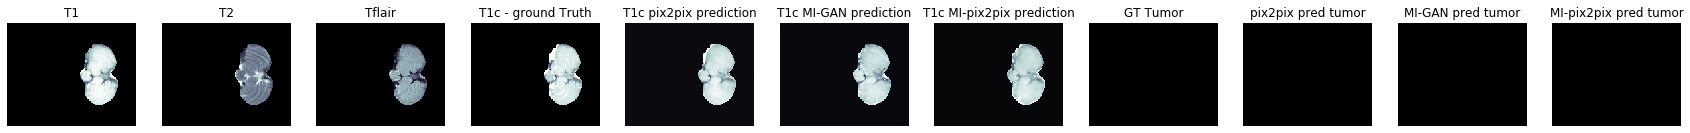

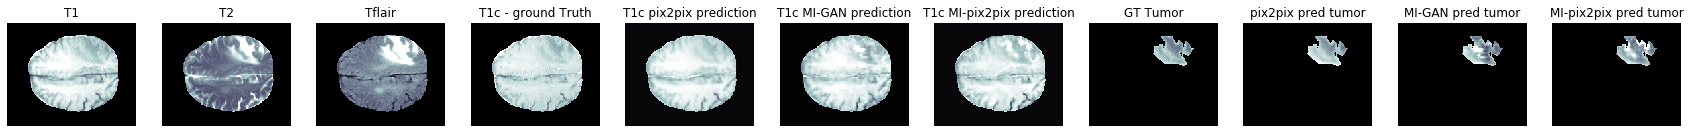

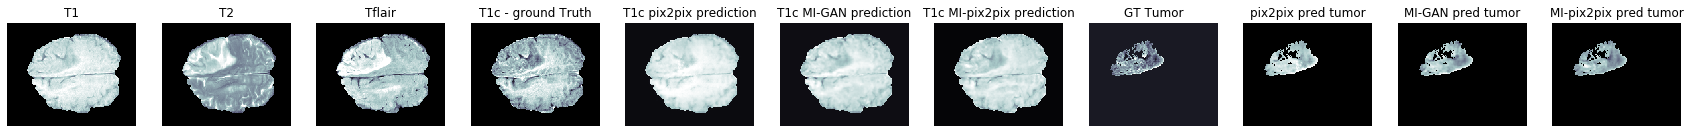

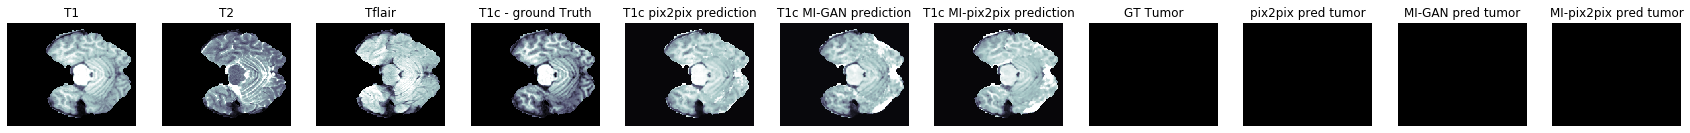

PSNR pix2pix on test set: 24.6165 ± 4.0755
MSE pix2pix on test set: 0.0051 ± 0.0048
SSIM pix2pix on test set: 0.8139 ± 0.0996

PSNR MI-GAN on test set: 23.9242 ± 3.6958
MSE MI-GAN on test set: 0.0054 ± 0.0040
SSIM MI-GAN on test set: 0.8027 ± 0.1003

PSNR MI-pix2pix on test set: 24.1597 ± 3.8631
MSE MI-pix2pix on test set: 0.0052 ± 0.0040
SSIM MI-pix2pix on test set: 0.8110 ± 0.0963

PSNR pix2pix wrt tumor area on test set: 20.6981 ± 4.9762
MSE pix2pix wrt tumor area on test set: 0.0155 ± 0.0199
SSIM pix2pix wrt tumor area on test set: 0.9835 ± 0.0277

PSNR MI-GAN wrt tumor area on test set: 19.9779 ± 4.3568
MSE MI-GAN wrt tumor area on test set: 0.0157 ± 0.0162
SSIM MI-GAN wrt tumor area on test set: 0.9825 ± 0.0286

PSNR MI-pix2pix wrt tumor area on test set: 19.8441 ± 4.6258
MSE MI-pix2pix wrt tumor area on test set: 0.0168 ± 0.0172
SSIM MI-pix2pix wrt tumor area on test set: 0.9828 ± 0.0282


In [0]:
evaluate_GAN(pix2pix_t1c, MI_GAN_t1c, MI_pix2pix_t1c, dataset=testing, set_type='test', evaluate_tumor_area=True)